In [241]:
import numpy as np


In [242]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


In [243]:
def sigmoid_derivative(x):
    return x * (1 - x)

In [244]:
def cross_entropy(y_pred, y_true):
    # Ensure prediction is not exactly 0 or 1
    y_pred = np.clip(y_pred, 1e-12, 1 - 1e-12)
    # Calculate cross-entropy loss
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))


In [245]:
class MLP:
    
    def __init__(self, random_values=True):
        # global variable to store hidden layer outputs
        self.hidden_layer_outputs = []
        # Ensure that the random values are always the same (for consistency and comparisons saks)
        seed = 42
        np.random.seed(seed)
        if not random_values:
            # Initialize weights and biases to zero
            self.weights1 = np.zeros((2, 10))
            self.weights2 = np.zeros((10, 10))
            self.weights3 = np.zeros((10, 2))
            self.bias1 = np.zeros((1, 10))
            self.bias2 = np.zeros((1, 10))
            self.bias3 = np.zeros((1, 2))
        else:
            # Initialize weights and biases randomly
            self.weights1 = np.random.rand(2, 10)
            self.weights2 = np.random.rand(10, 10)
            self.weights3 = np.random.rand(10, 2)
            self.bias1 = np.random.rand(1, 10)
            self.bias2 = np.random.rand(1, 10)
            self.bias3 = np.random.rand(1, 2)

    def forward(self, X, save=False):
        self.layer1 = sigmoid(np.dot(X, self.weights1) + self.bias1)
        self.layer2 = sigmoid(np.dot(self.layer1, self.weights2) + self.bias2)
        self.output = sigmoid(np.dot(self.layer2, self.weights3) + self.bias3)
        if save:
            self.hidden_layer_outputs.append((self.layer1, self.layer2))
        return self.output

    def backward(self, X, y, learning_rate):
        # error (pred - label)
        output_layer_error = self.output - y

        # deriv. for weights and biases
        d_weights3 = np.dot(self.layer2.T, output_layer_error)
        d_bias3 = np.sum(output_layer_error, axis=0, keepdims=True)

        # backpropagation
        hidden_layer_error2 = np.dot(output_layer_error, self.weights3.T) * sigmoid_derivative(self.layer2)
        d_weights2 = np.dot(self.layer1.T, hidden_layer_error2)
        d_bias2 = np.sum(hidden_layer_error2, axis=0, keepdims=True)

        hidden_layer_error1 = np.dot(hidden_layer_error2, self.weights2.T) * sigmoid_derivative(self.layer1)
        d_weights1 = np.dot(X.T, hidden_layer_error1)
        d_bias1 = np.sum(hidden_layer_error1, axis=0, keepdims=True)

        # Update weights and bias
        self.weights3 -= learning_rate * d_weights3
        self.bias3 -= learning_rate * d_bias3
        self.weights2 -= learning_rate * d_weights2
        self.bias2 -= learning_rate * d_bias2
        self.weights1 -= learning_rate * d_weights1
        self.bias1 -= learning_rate * d_bias1


    def train(self, X_train, y_train, epochs, learning_rate):
        loss_list = []
        for epoch in range(epochs):
            # Forward pass
            self.forward(X_train)

            # Backward pass and weight update
            self.backward(X_train, y_train, learning_rate)

            # Print the loss every 10 epochs
            if epoch % 10 == 0:
                loss = cross_entropy(self.forward(X_train), y_train)
                loss_list.append((loss, epoch))
            if epoch == epochs // 2 or epoch == 0 or epoch == epochs - 1 :
                self.forward(X_train, save=True)
                
        return loss_list


    def weighted_train(self, X_train, y_train, epochs, learning_rate, weight_init):
        # Initialize weights and biases randomly with the specified std
        rng = np.random.default_rng()
        self.weights1 = rng.normal(0, weight_init, size=(2, 10))
        self.weights2 = rng.normal(0, weight_init, size=(10, 10))
        self.weights3 = rng.normal(0, weight_init, size=(10, 2))
        self.bias1 = rng.normal(0, weight_init, size=(1, 10))
        self.bias2 = rng.normal(0, weight_init, size=(1, 10))
        self.bias3 = rng.normal(0, weight_init, size=(1, 2))
        loss_list = []
        for epoch in range(epochs):
            # Forward pass
            self.forward(X_train)

            # Backward pass and weight update
            self.backward(X_train, y_train, learning_rate)

            # Print the loss every 10 epochs
            if epoch % 10 == 0:
                loss = cross_entropy(self.forward(X_train), y_train)
                # print(f"Epoch {epoch}, Current loss: {loss}")
                loss_list.append((loss, epoch))
            if epoch == epochs // 2 or epoch == 0 or epoch == epochs - 1 :
                self.forward(X_train, save=True)
        return loss_list


In [246]:
import matplotlib.pyplot as plt

def plot_loss_function(evaluation_list):
    """
    Takes a list of tuples (loss value, epoch) and plots it
    """
    loss_list = [item[0] for item in evaluation_list]
    epochs = [item[1] for item in evaluation_list]

    # Plotting
    plt.plot(epochs, loss_list, marker='o', linestyle='-')
    plt.xlabel('Epochs')
    plt.ylabel('Loss Values')
    plt.title('Loss function')
    plt.grid(True)
    plt.show()

In [247]:
def standardize_data(X):
    # Calculate the mean and standard deviation for each feature, alternative to sklearn
    means = np.mean(X, axis=0)
    stds = np.std(X, axis=0)

    # Standardize each feature
    X_standardized = (X - means) / stds
    return X_standardized

In [248]:
import pandas as pd

# Load training dataset
train_df = pd.read_excel("./THA3train.xlsx")
X_train = train_df.iloc[:, :-1].values
y_train = train_df.iloc[:, -1].values

# One-hot encoding for two-class classification
y_train_one_hot = np.zeros((y_train.size, y_train.max() + 1))
y_train_one_hot[np.arange(y_train.size), y_train] = 1

X_train_scaled = standardize_data(X_train)

# Load test dataset
test_df = pd.read_excel('./THA3validate.xlsx')
X_test = test_df.iloc[:, :-1].values
y_test = test_df.iloc[:, -1].values

# One-hot encoding
y_test_one_hot = np.zeros((y_test.size, y_test.max() + 1))
y_test_one_hot[np.arange(y_test.size), y_test] = 1

# Standardize
X_test_scaled = standardize_data(X_test)

# Print shapes of the datasets
X_train_scaled.shape, y_train_one_hot.shape, X_test_scaled.shape, y_test_one_hot.shape


((410, 2), (410, 2), (82, 2), (82, 2))

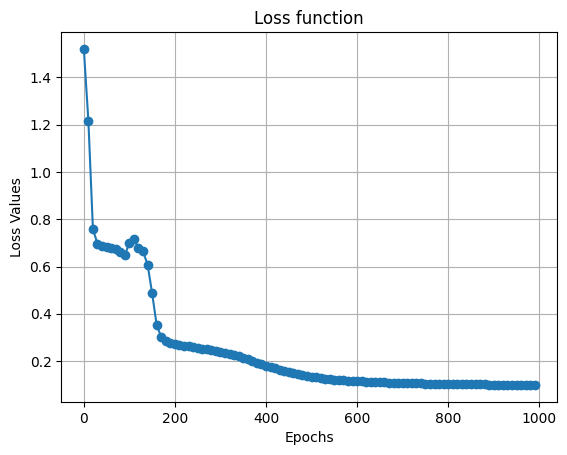

In [249]:


# Initialize MLP model
mlp = MLP()

# Train model
evaluation_list = mlp.train(X_train_scaled, y_train_one_hot, epochs=1000, learning_rate=0.004)
plot_loss_function(evaluation_list)
# print(f"Hidden layer outputs. All {mlp.hidden_layer_outputs}")
# print(len(mlp.hidden_layer_outputs))


In [250]:
from sklearn.metrics import accuracy_score, confusion_matrix

def evaluate_model(model, X_test, y_test):
    # Pred
    y_pred = model.forward(X_test)

    # Convert predictions and true values to class labels
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(y_test, axis=1)

    # Calculate accuracy
    accuracy = accuracy_score(y_true_labels, y_pred_labels)

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

    return accuracy, conf_matrix

# Evaluate the model on the validation set
accuracy, conf_matrix = evaluate_model(mlp, X_test_scaled, y_test_one_hot)

# Print the results
accuracy, conf_matrix



(0.975609756097561,
 array([[40,  1],
        [ 1, 40]], dtype=int64))

## Part B
### Point B - 1

First we initialize the model with weights and biases equal to zero, instead of randomizing them.

Performance of the model with zero-initialized parameters:
Accuracy: 0.975609756097561
Confusion Matrix:
[[40  1]
 [ 1 40]]


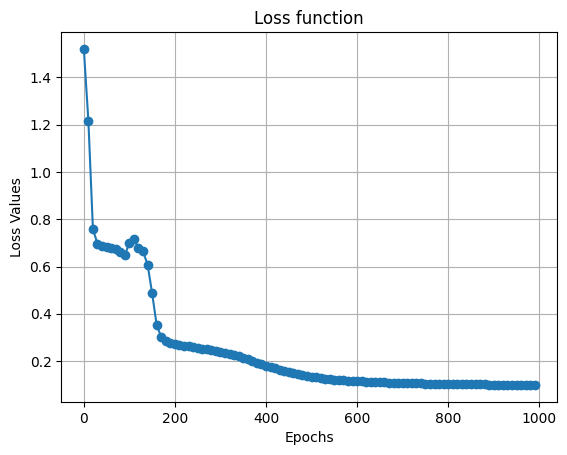

In [251]:

mlp_zeros = MLP(random_values=True)
evaluation_list = mlp_zeros.train(X_train_scaled, y_train_one_hot, epochs=1000, learning_rate=0.004)
accuracy_zero_initialized, conf_matrix = evaluate_model(mlp_zeros, X_test_scaled, y_test_one_hot)

print("Performance of the model with zero-initialized parameters:")
print(f"Accuracy: {accuracy_zero_initialized}")
print("Confusion Matrix:")
print(conf_matrix)

plot_loss_function(evaluation_list)

In comparison to the best model from Part A, this models loss function gets smaller much faster. It reaches values lower than 0.2 in around 200 epochs, while the model from Part A needs arould 300 epochs to reach similar values. The resulting confusion matrix and accuracy value are essentially the same.

### Point B - 2

In [252]:
learning_rates = [0.00001, 0.0001, 0.001, 0.01, 0.1]
weight_inits = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

results = []

for learning_rate in learning_rates:
    for weight_init in weight_inits:
        mlp = MLP()
        loss_list = mlp.weighted_train(X_train_scaled, y_train_one_hot, epochs=1000, learning_rate=learning_rate, weight_init=weight_init)
        accuracy, conf_matrix = evaluate_model(mlp, X_test_scaled, y_test_one_hot)
        results.append((learning_rate, weight_init, accuracy, conf_matrix, loss_list, mlp.hidden_layer_outputs))




In [253]:
print(results[0][0])
print(results[0][1])
print(results[0][2])
print(results[0][3])

1e-05
0.1
0.5121951219512195
[[41  0]
 [40  1]]


In [254]:
def create_heatmap(weight_inits, learning_rates, accuracies):
    """
    or just create_heatmap(x, y, colour)
    """

    learning_rates_size = len(set(learning_rates))
    weight_inits_size = len(set(weight_inits))
    print(learning_rates_size)
    print(weight_inits_size)

    # Reshape the accuracies into a 2D array for the heatmap
    accuracy_matrix = np.array(accuracies).reshape(learning_rates_size, weight_inits_size)
    

    # Create a heatmap
    plt.imshow(accuracy_matrix, cmap='viridis', origin='lower', aspect='auto')

    # Set axis labels and ticks
    plt.xlabel('Weight Initialization (σ^2)')
    plt.ylabel('Learning Rate')
    plt.xticks(np.arange(weight_inits_size), sorted(set(weight_inits)))
    plt.yticks(np.arange(learning_rates_size), sorted(set(learning_rates)))

    # Display color bar
    cbar = plt.colorbar()
    cbar.set_label('Accuracy')

    # Show the plot
    plt.show()


10
5


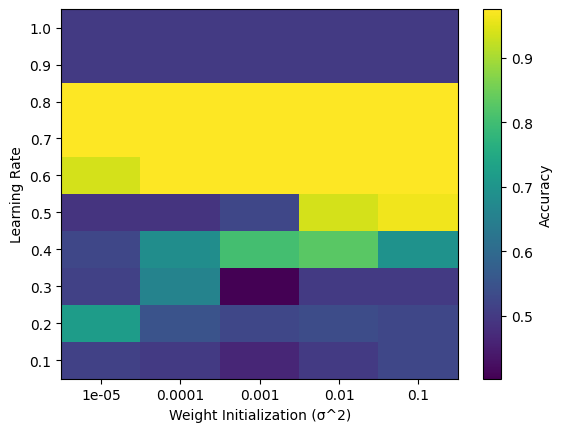

In [255]:
learning_rates = [result[0] for result in results]
weight_inits = [result[1] for result in results]
accuracies = [result[2] for result in results]
create_heatmap(learning_rates, weight_inits, accuracies)

### Point B - 3

In [256]:
print("Worst one")
worst_result = results[7]
print(worst_result[0])
print(worst_result[1])
print(f"Accuracy {worst_result[2]}")
print("Best one")
best_result = results[31]
print(best_result[0])
print(best_result[1])
print(f"Accuracy {best_result[2]}")

Worst one
1e-05
0.8
Accuracy 0.524390243902439
Best one
0.01
0.2
Accuracy 0.975609756097561


In [257]:
def one_last_heatmap(resulting_tuple): #CleanCode
    # Convert the list of tuples to a 3D NumPy array
    heatmap_data = np.array([np.array(t) for t in resulting_tuple[4]])

    # Plot the heatmap
    plt.imshow(heatmap_data, cmap='viridis', origin='lower', aspect='auto')

    # Set axis labels and ticks
    plt.xlabel('Hidden Neuron ID')
    plt.ylabel('Data Points ID')

    cbar = plt.colorbar()

    # Show the plot
    plt.show()

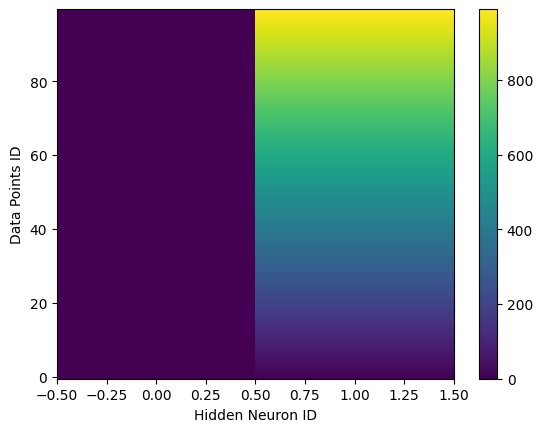

In [258]:
one_last_heatmap(worst_result)

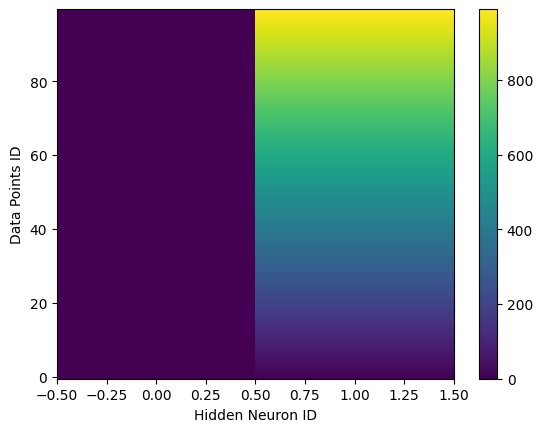

In [259]:
one_last_heatmap(best_result)